# Task Duration Estimation Model v2.0

1. Import Libraries
2. Loading Dataset<br>
 **2.A** Frequency Distribution<br>
 **2.B** Histogram and Removing Outliers<br>
 **2.C** KDE plot for Actual Hours<br>
3. Processing Embeddings using fine-tuned BERT-Uncased<br>
4. Kernel PCA (KPCA) Dimensionality Reduction<br>
 **4.A** KPCA Optuna Optimization<br>
 **4.B** KPCA Model Saving<br>
 **4.C** KPCA Plotting with Gradient Labels<br>
 **4.D** Spearman Correlation for 3D Embeddings<br>
5. Detection and Removal of Outliers<br>
 **5.A** Optimized MLP for prediction<br>
 **5.B** Residual plotting in 3D Feature Surface<br>
 **5.C** Histogram of Residuals<br>
 **5.D** Cleaned Data after Removing High Residuals<br>
6. Training and Testing Regression Models<br>
 **6.A** LazyRegessor Training and Testing<br>
 **6.B** Top 1 Best LazyRegressor Model (NuSVR) - Optimized<br>
 **6.C** Top 2 Best LazyRegressor Model (MLP) - Optimized<br>
 **6.D** Top-k Ensemble Model via Voting - Optimized<br>
 **6.E** XGBoost Regressor - Optimized<br>
 **6.F** Bi-LSTM Regressor - Optimized<br>
7. Inference Testing via Gradio<br>



In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


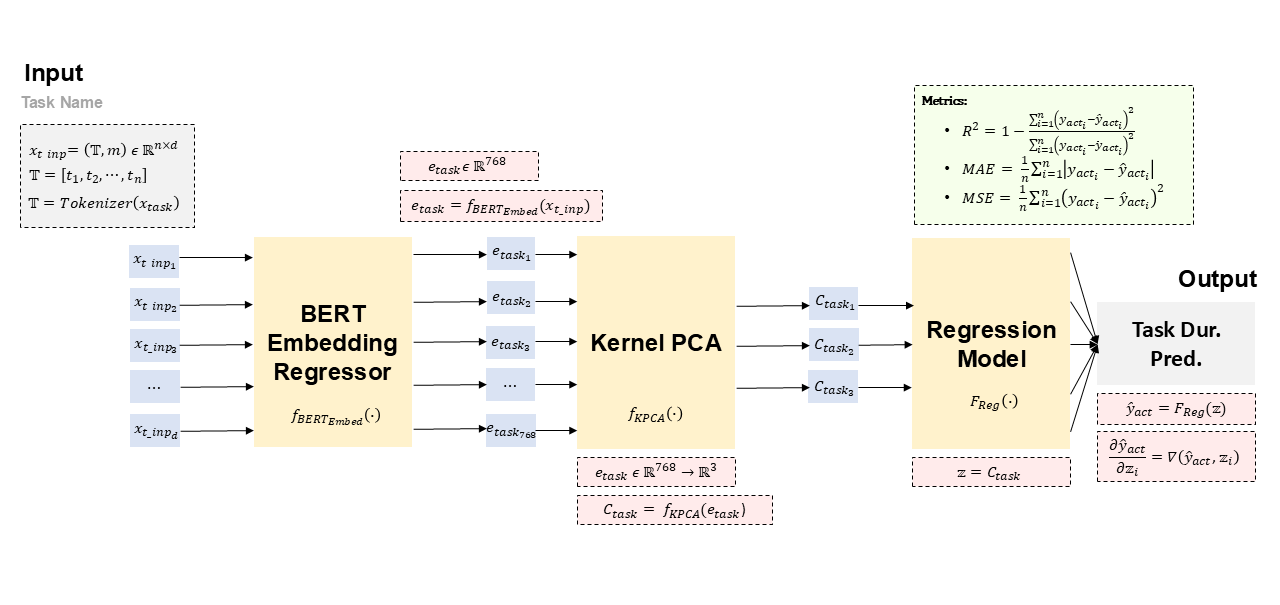

In [6]:
!cp "/content/drive/Shareddrives/task-estimation/Attempt1_Regressor_from_Embeddings/PLAN6.png" .
from IPython.display import Image, display

# Display the image
display(Image(filename='PLAN6.png'))

# 1. Import Libraries

In [ ]:
import pandas as pd # For transforming JSON data into a pandas dataframe
import numpy as np # For computations of probabilities, perplexities and expected count
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from typing import Iterator
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from lazypredict.Supervised import LazyRegressor


from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import optuna


from sklearn.preprocessing import MinMaxScaler

# 2. Loading Data


In [ ]:
# 2.0.1: CSV path
csv_path = (r'C:\Users\Jeryl Salas\OneDrive\Documents\AI Work\TaskEstimator\CLEANED_ONE_HOT_developers_estimation_data_july_24_hour_09.csv')

# 2.0.2: Load the dataset from CSV
df = pd.read_csv(csv_path)
print(df.head())

                                           task_name  task_actual_hours  \
0  Automation | Time/Money: Timelogs | Viewing of...              12.23   
1  OPF: Org/Workforce Executive - Memorandums: No...               0.77   
2  OPF: Org Executive: Breach of Contract Amount ...               0.00   
3  OPF: Issues-Card: Unable to create a card if n...               1.35   
4  OPF: Issues - Card Creation Modal - All Member...               0.00   

   estimation_hours                employee_name  years_of_experience  \
0             12.00                Lydia Karungi                    3   
1             16.00  Osho Gautama Mahavir Zaldua                    2   
2              4.00       Raymond Christian Diez                    2   
3             16.00  Osho Gautama Mahavir Zaldua                    2   
4              8.00              Daniel Bongomin                    3   

   team_size  estimation_interest  estimation_confidence  \
0         10               100.00                 

## 2.A Frequency Distribution
- This is done to see the distribution of task actual hours

In [ ]:
frequency_distribution = df['task_actual_hours'].value_counts().sort_index()
print(frequency_distribution)

task_actual_hours
0.00      188
0.00        1
0.00        1
0.00        1
0.08        1
         ... 
92.58       1
93.17       1
95.73       1
296.96      1
373.82      1
Name: count, Length: 4142, dtype: int64


## 2.B Histogram and Removing Outliers
- Displaying distribution of task actual hours. We see that its right-skewed distribution. Our goal is to remove the right outliers that may affect our training and testing of regression models.
    - a. Remove actual hours that are zero: there are tasks that weren't used
    - b. Remove actual hours that are abnormally large: remove values greater than 95% quantile

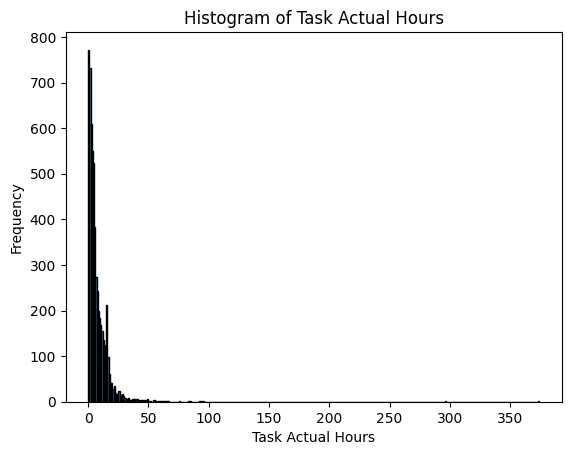

In [ ]:
import matplotlib.pyplot as plt

# 2.B.1: Plot histogram of 'task_actual_hours' from 0 to the maximum value
plt.hist(df['task_actual_hours'], bins=range(0, int(df['task_actual_hours'].max()) + 2), edgecolor='black')
plt.xlabel('Task Actual Hours')
plt.ylabel('Frequency')
plt.title('Histogram of Task Actual Hours')
plt.show()

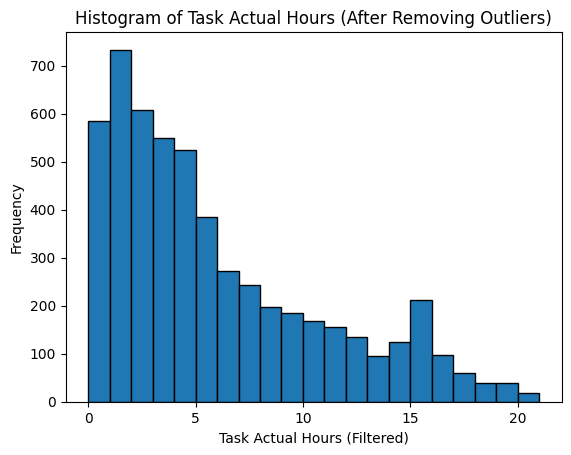

In [ ]:
# 2.B.2: Remove values greater than the 95th percentile
upper_limit = df['task_actual_hours'].quantile(0.95)
df_filtered = df[(df['task_actual_hours'] <= upper_limit) & (df['task_actual_hours'] > 0)]

# 2.B.3: Plot the histogram after filtering out outliers
plt.hist(df_filtered['task_actual_hours'], bins=range(0, int(df_filtered['task_actual_hours'].max()) + 2), edgecolor='black')
plt.xlabel('Task Actual Hours (Filtered)')
plt.ylabel('Frequency')
plt.title('Histogram of Task Actual Hours (After Removing Outliers)')
plt.show()

In [ ]:
# 2.B.4: Number of rows before and after filtering
original_count = len(df)
filtered_count = len(df_filtered)
filtered_out_count = original_count - filtered_count

# 2.B.5: Display the result
print(f"Original count: {original_count}")
print(f"Filtered count: {filtered_count}")
print(f"Number of rows filtered out: {filtered_out_count}")

Original count: 5911
Filtered count: 5427
Number of rows filtered out: 484


## 2.C KDE plot for Actual Hours
- We display Kernel Density Estimation plots for task actual hours

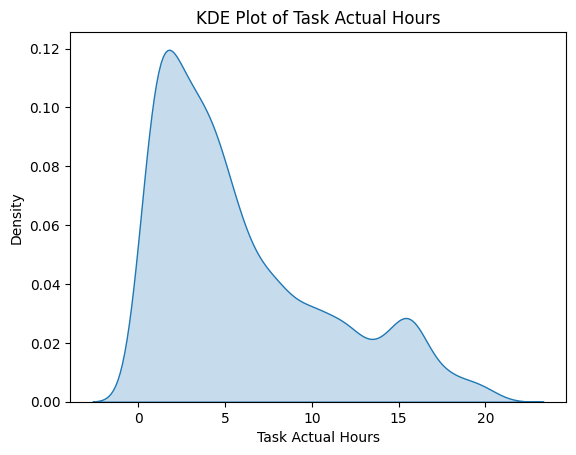

In [ ]:
import seaborn as sns

# 2.C.1: Plot KDE for task_actual_hours
sns.kdeplot(df_filtered['task_actual_hours'], fill=True)

# 2.C.2: Add labels and title
plt.xlabel('Task Actual Hours')
plt.ylabel('Density')
plt.title('KDE Plot of Task Actual Hours')
plt.show()

# 2.C.3: Use filtered dataframe as the "default" dataframe
df = df_filtered

# 3. Processing Embeddings using fine-tuned BERT-Uncased
- We process tokens for embeddings using a fine-tuned BERT model.
    - Tokenization with padding and truncation
    - Embedding

- Input Tokens:
$$
\mathbf{T} = [t_1, t_2, \cdots, t_n] \\
\mathbf{T} = Tokenizer(x_{task}) \\
x_{t\_inp} = (\mathbf{T}, m) \in \mathbb{R}^{n \times d}
$$

- BERT Model:
$$
f_{BERT_{Embed}}(\cdot)
$$

- Embedding Vectors:
$$e_{task} = f_{BERT_{Embed}}(x_{t\_inp})$$

In [ ]:
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using device: {device}")

# 3.0.1: Import fine-tuned BERT model
model = AutoModel.from_pretrained(r'C:/Users/Jeryl Salas/AppData/Local/Programs/Microsoft VS Code/bert-task-regressor').to(device)
tokenizer = AutoTokenizer.from_pretrained(r'C:/Users/Jeryl Salas/AppData/Local/Programs/Microsoft VS Code/bert-task-regressor')

embeddings = []
def process_embeddings(tokens):
    embeddings = []
    for sentence in tqdm(tokens, desc="Processing tokens"):

        inputs = tokenizer(sentence, padding=True, truncation=True, return_tensors="pt").to(device)

        with torch.no_grad():
          outputs = model(**inputs)
          embedding = outputs.last_hidden_state[:, 0, :]  # CLS embeddings
          embeddings.append(embedding)  # Append to llama_embeddings (list)
        # print(embedding.shape)
        # print(embedding)  # (batch_size, hidden_size)

    return torch.cat(embeddings, dim=0)

# 3.0.2: Main Command for extracting embeddings from task names
tn = process_embeddings(df['task_name'])

using device: cuda


Processing tokens: 100%|██████████| 5427/5427 [01:24<00:00, 64.41it/s]


In [ ]:
# 3.0.3: Print first 10 embedding vectors
print(tn[:10])

tensor([[-0.1090,  0.9317, -0.4535,  ..., -0.3950, -0.3878, -0.2235],
        [ 0.3717, -0.0794, -0.6194,  ..., -0.5471, -0.1697,  0.2181],
        [-0.3799,  0.2777, -0.5741,  ..., -0.3209, -0.4413,  0.0618],
        ...,
        [-0.4579,  0.5523, -0.4301,  ..., -0.1723, -0.4923, -0.1386],
        [ 0.5964,  0.1428, -0.7133,  ..., -0.5771, -0.0741, -0.1284],
        [ 0.4858,  0.0970, -0.6202,  ..., -0.5124, -0.1921, -0.1701]],
       device='cuda:0')


In [ ]:
# 3.0.4: Convert embeddings tensor to NumPy array and reshape
tn_arr = tn.cpu().numpy()  # Moving tensor to CPU and convert to NumPy
tn_arr = tn_arr.reshape(tn_arr.shape[0], -1)  # Flatten

# 3.0.5: Target variable (actual task hours)
y = np.array(df['task_actual_hours'])

# 4. Kernel PCA (KPCA) Dimensionality Reduction
The data was transformed using Kernel PCA (KPCA) with optimized hyperparameters determined by Optuna. The transformed embedding is computed as:
$$
\mathbf{\tilde{e}}_{\text{task}} = \frac{\mathbf{e}_{\text{task}} - \mu}{\sigma}
$$


$$
\mathbf{\hat{e}}_{\text{task}} = \sum_{i=1}^{n} \alpha_i k(\tilde{e}_{\text{task}}, e_{i}) \mathbf{v}_{i}
$$

where:

- $ e_{\text{task}} \in \mathbb{R}^{768} $ is the original embedding in the $768$-dimensional space.
- $ \alpha_i $ are the expansion coefficients obtained from solving the eigenvalue problem in the feature space.
- $ k(e_{\text{task}}, e_i) $ is the kernel function:
- $ \mathbf{v}_i $ are the eigenvectors of the kernel matrix corresponding to the top 3 eigenvalues (for 3D reduction).
- $ \mathbf{e}_{\text{task}} \in \mathbb{R}^{768} \to \mathbb{R}^{3} $, where the reduced embedding resides in a 3-dimensional space.



### Hyperparameters:

1. **Degree ($\text{degree}$)**: Controls the degree of the polynomial kernel.
2. **$\text{coef0}$**: Adds a constant to the dot product in the polynomial or sigmoid kernel.
3. **Gamma ($\gamma$)**: Defines the scale of the RBF, polynomial, or sigmoid kernel.
4. **$\alpha$**: Expansion coefficients obtained as part of the KPCA optimization.



## 4.A KPCA Optuna Optimization
$$
\min_{\mathbf{v}_1, \mathbf{v}_2, \dots, \mathbf{v}_k} \sum_{i=1}^n \| \mathbf{e}_{\text{task}}^{(i)} - \hat{\mathbf{e}}_{\text{task}}^{(i)} \|^2
$$

where:

- $ \mathbf{e}_{\text{task}}^{(i)} $ is the original embedding of the $i$-th task in $ \mathbb{R}^{768} $.
- $ \hat{\mathbf{e}}_{\text{task}}^{(i)} $ is the reconstructed embedding, defined as:
  $$
  \hat{\mathbf{e}}_{\text{task}}^{(i)} = \sum_{j=1}^k \langle \mathbf{e}_{\text{task}}^{(i)}, \mathbf{v}_j \rangle \mathbf{v}_j
  $$

- $ \mathbf{v}_j $ are the eigenvectors of the kernel matrix corresponding to the top $k$ eigenvalues.
- $ \| \cdot \|^2 $ is the squared Euclidean norm.


[I 2025-01-14 21:14:16,514] A new study created in memory with name: no-name-82cf8c3a-5bad-47f8-91a7-2cd073aa9f4e
[I 2025-01-14 21:14:18,683] Trial 0 finished with value: 0.3941664695739746 and parameters: {'kernel': 'poly', 'gamma': 0.00691225564022752, 'coef0': 0.5291318677223149, 'alpha': 0.002612472112180634}. Best is trial 0 with value: 0.3941664695739746.
[I 2025-01-14 21:14:20,885] Trial 1 finished with value: 0.39853039383888245 and parameters: {'kernel': 'poly', 'gamma': 0.010584181868211334, 'coef0': 0.5362584274998529, 'alpha': 0.008930710009294286}. Best is trial 0 with value: 0.3941664695739746.
[I 2025-01-14 21:14:23,144] Trial 2 finished with value: 0.40773287415504456 and parameters: {'kernel': 'poly', 'gamma': 0.011219572219464593, 'coef0': 0.49459739200285296, 'alpha': 0.00016777159492006047}. Best is trial 0 with value: 0.3941664695739746.
[I 2025-01-14 21:14:25,743] Trial 3 finished with value: 0.40223002433776855 and parameters: {'kernel': 'poly', 'gamma': 0.011664

Trial failed with kernel=poly, gamma=0.01450281419950806, degree=2, coef0=0.45010252979850457
Error: Matrix is singular.


[I 2025-01-14 21:14:29,788] Trial 5 finished with value: 0.40018007159233093 and parameters: {'kernel': 'poly', 'gamma': 0.011614355673126842, 'coef0': 0.5353600890775579, 'alpha': 0.0025929722081107255}. Best is trial 0 with value: 0.3941664695739746.
[I 2025-01-14 21:14:32,174] Trial 6 finished with value: 0.39585044980049133 and parameters: {'kernel': 'poly', 'gamma': 0.007680982124474149, 'coef0': 0.4860004392257967, 'alpha': 0.003659975909141541}. Best is trial 0 with value: 0.3941664695739746.
[I 2025-01-14 21:14:34,514] Trial 7 finished with value: 0.4089803695678711 and parameters: {'kernel': 'poly', 'gamma': 0.014573133451765313, 'coef0': 0.4914656731641263, 'alpha': 0.006124040404471509}. Best is trial 0 with value: 0.3941664695739746.
[I 2025-01-14 21:14:36,820] Trial 8 finished with value: 0.41841793060302734 and parameters: {'kernel': 'poly', 'gamma': 0.01482976716971534, 'coef0': 0.4280564746459647, 'alpha': 0.0006670272930178432}. Best is trial 0 with value: 0.3941664695

Best hyperparameters: {'kernel': 'poly', 'gamma': 0.006009853002075805, 'coef0': 0.5431033441241493, 'alpha': 0.0007289895543681743}
Best reconstruction error: 0.39319756627082825


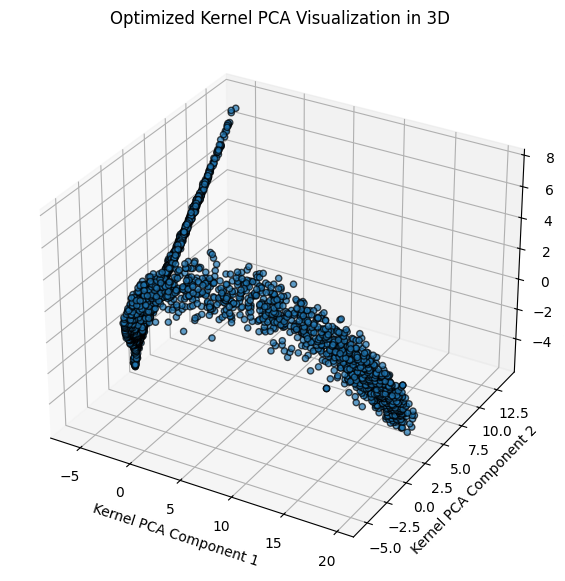

In [ ]:

# 4.A.1: Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(tn_arr)

# 4.A.2: Define the objective function for Optuna
def objective(trial):
    try:
        kernel = trial.suggest_categorical("kernel", ["poly"])
        gamma = trial.suggest_uniform("gamma", 0.006, 0.015)
        degree = 2
        coef0 = trial.suggest_uniform("coef0", 0.40, 0.55)
        alpha = trial.suggest_uniform("alpha", 1e-4, 1e-2)

        kpca = KernelPCA(
            n_components=3,  # Set to 3 for 3D visualization
            kernel=kernel,
            gamma=gamma,
            degree=degree if degree is not None else 3,
            coef0=coef0 if coef0 is not None else 0,
            fit_inverse_transform=True,
            alpha=alpha,
            random_state=42
        )

        kpca.fit(X_scaled)
        X_kpca = kpca.transform(X_scaled)


        X_reconstructed = kpca.inverse_transform(X_kpca)
        reconstruction_error = mean_squared_error(X_scaled, X_reconstructed)

        return reconstruction_error

    except (ValueError, np.linalg.LinAlgError) as e:
        print(f"Trial failed with kernel={kernel}, gamma={gamma}, degree={degree}, coef0={coef0}")
        print(f"Error: {e}")
        return float("inf")


# 4.A.3: Run the Optuna study
optuna.logging.set_verbosity(optuna.logging.INFO)
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

# 4.A.4: Best hyperparameters
best_params = study.best_params
print("Best hyperparameters:", best_params)
print("Best reconstruction error:", study.best_value)

# 4.A.5: Use the best hyperparameters for Kernel PCA
kpca_best = KernelPCA(
    n_components=3,  # Set to 3 for 3D visualization
    kernel=best_params["kernel"],
    gamma=best_params["gamma"],
    degree=best_params.get("degree", 3),
    coef0=best_params.get("coef0", 0)
)
X_kpca_best = kpca_best.fit_transform(X_scaled)

# 4.A.6: Visualize the optimized Kernel PCA output in 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    X_kpca_best[:, 0],
    X_kpca_best[:, 1],
    X_kpca_best[:, 2],
    alpha=0.7,
    edgecolors='k'
)

ax.set_title("Optimized Kernel PCA Visualization in 3D")
ax.set_xlabel("Kernel PCA Component 1")
ax.set_ylabel("Kernel PCA Component 2")
ax.set_zlabel("Kernel PCA Component 3")
plt.show()


## 4.B KPCA Model Saving

In [ ]:
import joblib

# 4.B.1: Save the scaler and KPCA model as a dictionary
model_data = {
    "scaler": scaler,
    "kpca": kpca_best
}

joblib.dump(model_data, "best_kpca_model_v2.pkl")
print("Best Kernel PCA and scaler saved to 'best_kpca_model_v2.pkl'")


Best Kernel PCA and scaler saved to 'best_kpca_model_v2.pkl'


## 4.C KPCA Plotting with Gradient Labels

The data was normalized using **MinMaxScaler()**, which scales the values of $y$ to $[0, 1]$.
$$
y_{\text{normalized}}^{(i)} = \frac{y^{(i)} - \min(y)}{\max(y) - \min(y)}
$$


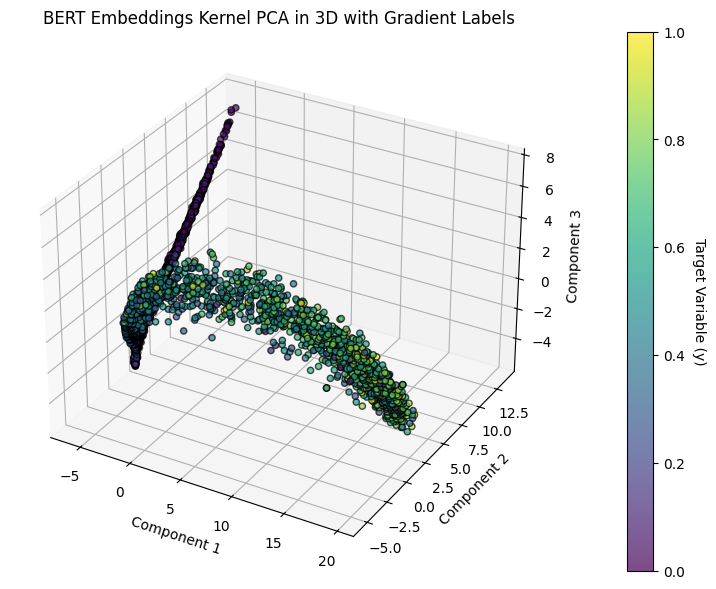

In [ ]:
# 4.C.1: Normalize y for color mapping
scaler = MinMaxScaler()
y_normalized = scaler.fit_transform(y.reshape(-1, 1)).flatten()

# 4.C.2: Plot in 3D with gradient
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    X_kpca_best[:, 0],
    X_kpca_best[:, 1],
    X_kpca_best[:, 2],
    c=y_normalized,
    cmap="viridis", # gradient
    alpha=0.7,
    edgecolors='k'
)

# 4.C.3: Add color bar to indicate the gradient
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label("Target Variable (y)", rotation=270, labelpad=15)
ax.set_title("BERT Embeddings Kernel PCA in 3D with Gradient Labels")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

plt.show()

## 4.D Spearman Correlation for 3D Embeddings
This analysis computes the correlation between pairwise distances in the 3D embedding space and pairwise absolute differences in task durations using Spearman's rank correlation coefficient.

### Steps:

1. **Pairwise Distances in the 3D Embedding Space**:
   Let the 3D embeddings be represented as $ \mathbf{X}_{\text{KPCA}} \in \mathbb{R}^{n \times 3} $. The pairwise distances between points in this space are computed as:

   $$
   D_{\text{embedding}}(i, j) = \|\mathbf{x}_i - \mathbf{x}_j\|_2
   $$

   where:
   - $ \mathbf{x}_i $ and $ \mathbf{x}_j $ are the embeddings of the $i$-th and $j$-th tasks, respectively.
   - $ \| \cdot \|_2 $ denotes the Euclidean distance.

   The pairwise distance matrix is:

   $$
   \mathbf{D}_{\text{embedding}} = \text{pdist}(\mathbf{X}_{\text{KPCA}})
   $$

2. **Pairwise Absolute Differences in Durations**:
   Let $ y \in \mathbb{R}^{n} $ be the vector of task durations. The pairwise absolute differences between durations are computed as:

   $$
   D_{\text{duration}}(i, j) = |y_i - y_j|
   $$

   The pairwise absolute difference matrix is:

   $$
   \mathbf{D}_{\text{duration}} = \text{pdist}(y)
   $$

3. **Spearman's Rank Correlation**:
   The Spearman correlation between the two distance matrices is computed as:

   $$
   \rho = \frac{\text{cov}(\text{rank}(\mathbf{D}_{\text{embedding}}), \text{rank}(\mathbf{D}_{\text{duration}}))}{\sigma_{\text{rank}(\mathbf{D}_{\text{embedding}})} \sigma_{\text{rank}(\mathbf{D}_{\text{duration}})}}
   $$

   where:
   - $ \text{rank}(\cdot) $ denotes the ranks of the flattened distance matrices.
   - $ \text{cov}(\cdot, \cdot) $ is the covariance.
   - $ \sigma_{\cdot} $ is the standard deviation.


In [ ]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import spearmanr

# 4.D.1: Pairwise distances in the 3D embedding space
embedding_distances = squareform(pdist(X_kpca_best))

# 4.D.2: Pairwise absolute differences in durations
duration_diff = squareform(pdist(y.reshape(-1, 1)))

# 4.D.3: Correlation between the two distance matrices
correlation, _ = spearmanr(embedding_distances.flatten(), duration_diff.flatten())
print(f"Spearman correlation between 3D embeddings and durations: {correlation:.3f}")

Spearman correlation between 3D embeddings and durations: 0.574


# 5. Detection and Removal of Outliers

In [ ]:
# 5.0.1: Training-test split
X_train, X_test, y_train, y_test = train_test_split(X_kpca_best, y, test_size=0.2, random_state=42)

## 5.A Optimized MLP for prediction

In [ ]:
import optuna
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


def objective(trial):
    hidden_layer_sizes = tuple([trial.suggest_int(f"n_units_{i}", 64, 512) for i in range(trial.suggest_int("n_layers", 1, 3))])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-3, log=True)
    alpha = trial.suggest_float("alpha", 1e-3, 1e-1, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    batch_size = trial.suggest_int("batch_size", 32, 128)

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=1000,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    if np.isnan(y_pred).sum() > 0:
        print("NaNs detected in predictions. Returning -inf to avoid errors.")
        return -np.inf

    return r2_score(y_test, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Trial:", study.best_trial)
best_params = study.best_trial.params

final_model = MLPRegressor(
    hidden_layer_sizes=tuple([best_params[f"n_units_{i}"] for i in range(best_params['n_layers'])]),
    max_iter=1000,
    learning_rate_init=best_params["learning_rate_init"],
    alpha=best_params["alpha"],
    activation=best_params["activation"],
    solver=best_params["solver"],
    batch_size=best_params["batch_size"],
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

mse_final = mean_squared_error(y_test, y_pred_final)
r2_final = r2_score(y_test, y_pred_final)

print(f"Optimized MLP - MSE: {mse_final:.4f}")
print(f"Optimized MLP - R²: {r2_final:.4f}")


[I 2025-01-14 18:37:16,059] A new study created in memory with name: no-name-f919ed01-a7a5-405e-9f6e-2605f3588a3e
[I 2025-01-14 18:37:33,430] Trial 0 finished with value: 0.6774175010636172 and parameters: {'n_layers': 2, 'n_units_0': 211, 'n_units_1': 351, 'learning_rate_init': 5.842116940643105e-05, 'alpha': 0.04386210970388543, 'activation': 'relu', 'solver': 'sgd', 'batch_size': 67}. Best is trial 0 with value: 0.6774175010636172.
[I 2025-01-14 18:37:34,829] Trial 1 finished with value: 0.6864014206021166 and parameters: {'n_layers': 1, 'n_units_0': 109, 'learning_rate_init': 0.0002578870069104693, 'alpha': 0.019767938212979983, 'activation': 'tanh', 'solver': 'sgd', 'batch_size': 119}. Best is trial 1 with value: 0.6864014206021166.
[I 2025-01-14 18:39:20,709] Trial 2 finished with value: 0.6812555630629046 and parameters: {'n_layers': 2, 'n_units_0': 512, 'n_units_1': 400, 'learning_rate_init': 1.3297023090973044e-05, 'alpha': 0.07180302356265263, 'activation': 'relu', 'solver': 

Best Trial: FrozenTrial(number=13, state=1, values=[0.6927619561544696], datetime_start=datetime.datetime(2025, 1, 14, 18, 43, 48, 247957), datetime_complete=datetime.datetime(2025, 1, 14, 18, 43, 53, 207295), params={'n_layers': 2, 'n_units_0': 365, 'n_units_1': 69, 'learning_rate_init': 0.0008159296894717613, 'alpha': 0.0024365220078752135, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 48}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=3, log=False, low=1, step=1), 'n_units_0': IntDistribution(high=512, log=False, low=64, step=1), 'n_units_1': IntDistribution(high=512, log=False, low=64, step=1), 'learning_rate_init': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'alpha': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'solver': CategoricalDistribution(choices=('adam', 'sgd')), 'batch_size': IntDistribution(high=128, log=Fals

## 5.B Residual plotting in 3D Feature Surface

This section visualizes the true target values, predicted target values, and the residuals (absolute errors) in the 3D feature space obtained from Kernel PCA. Here is where we'll find out what makes the results of $R^2$ and MSE low.

$$
r_i = |y_{\text{true}, i} - y_{\text{pred}, i}|
$$

where:
- $r_i$ is the residual for the $i$-th sample.
- $y_{\text{true}, i}$ is the true target value for the $i$-th sample.
- $y_{\text{pred}, i}$ is the predicted target value for the $i$-th sample.


1. **True Target Values in 3D Feature Space**:
   The true target values $y_{\text{true}}$ are visualized in the 3D embedding space:
   - Each point represents a test sample in the 3D space.
   - The color corresponds to the true target value.

2. **Predicted Target Values in 3D Feature Space**:
   The predicted target values $y_{\text{pred}}$ are visualized in the same 3D embedding space:
   - The predictions are from the Optimized MLP (**shown above**)
   - Each point represents a test sample.
   - The color corresponds to the predicted target value.

3. **True vs Predicted Target Values**:
   The true and predicted values are visualized together in the 3D embedding space:
   - True values are shown in one color map (**viridis**).
   - Predicted values are shown in another color map (**plasma**).

4. **Residuals (Absolute Errors)**:
   The residuals $r_i = |y_{\text{true}, i} - y_{\text{pred}, i}|$ are visualized as the color gradient in the 3D embedding space:
   - Each point represents a sample in the 3D space.
   - The color corresponds to the magnitude of the residuals.
   - A **coolwarm** colormap is used to highlight low to high residuals.

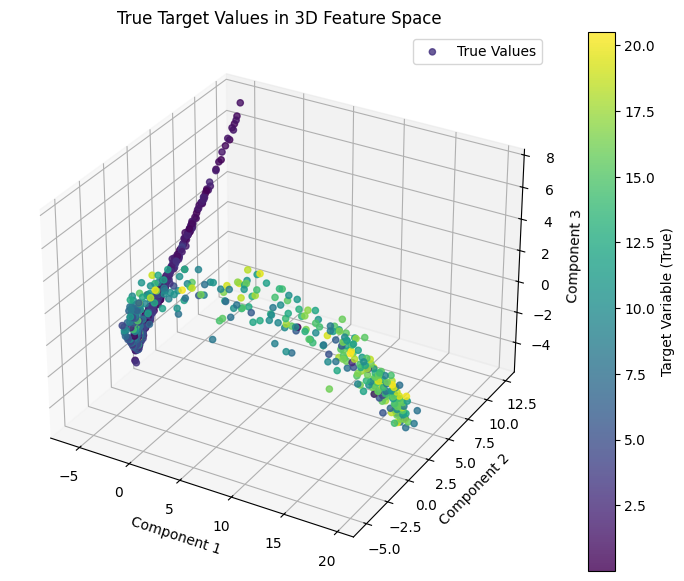

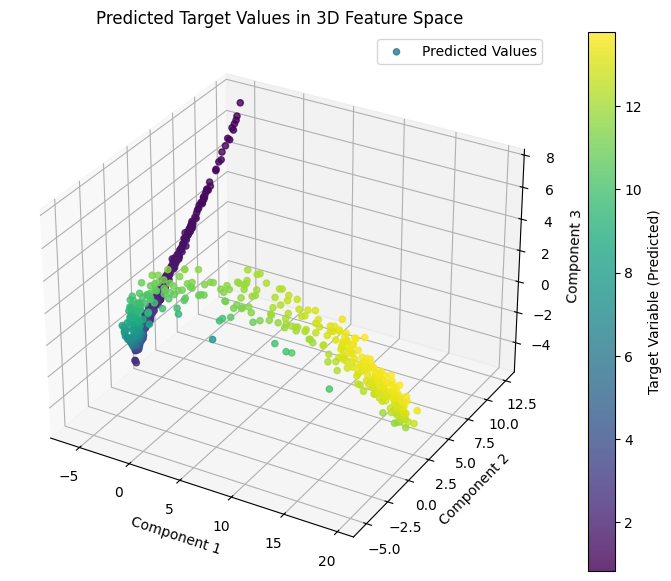

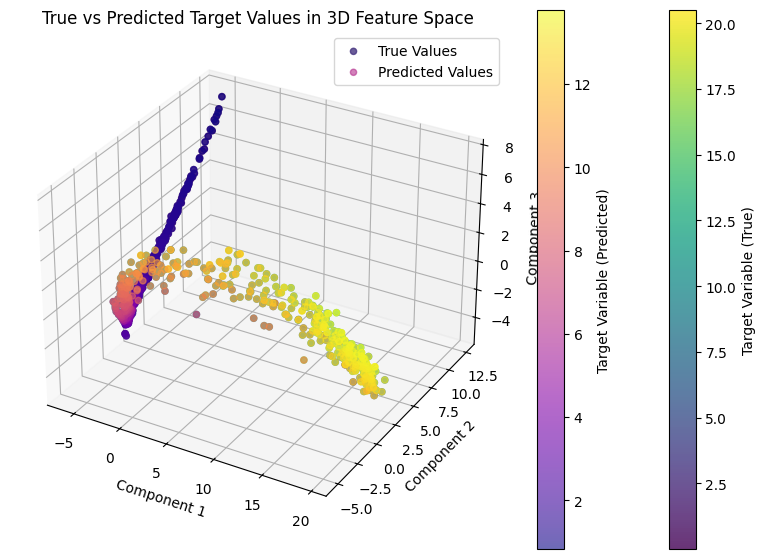

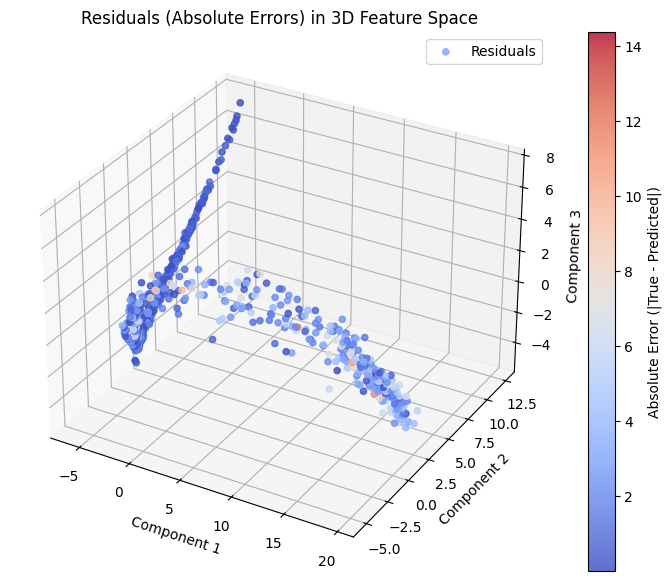

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# 5.B.1: Plot True Values
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    X_test[:, 0], X_test[:, 1], X_test[:, 2],
    c=y_test, cmap='viridis', label='True Values', alpha=0.8
)
plt.colorbar(sc, label="Target Variable (True)")
ax.set_title("True Target Values in 3D Feature Space")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.legend()
plt.show()

# 5.B.2: Plot Predicted Values
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    X_test[:, 0], X_test[:, 1], X_test[:, 2],
    c=y_pred_final, cmap='viridis', label='Predicted Values', alpha=0.8
)
plt.colorbar(sc, label="Target Variable (Predicted)")
ax.set_title("Predicted Target Values in 3D Feature Space")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.legend()
plt.show()

# 5.B.3: Combined True and Predicted Values
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc1 = ax.scatter(
    X_test[:, 0], X_test[:, 1], X_test[:, 2],
    c=y_test, cmap='viridis', label='True Values', alpha=0.8
)
sc2 = ax.scatter(
    X_test[:, 0], X_test[:, 1], X_test[:, 2],
    c=y_pred_final, cmap='plasma', label='Predicted Values', alpha=0.6
)
plt.colorbar(sc1, label="Target Variable (True)")
plt.colorbar(sc2, label="Target Variable (Predicted)")
ax.set_title("True vs Predicted Target Values in 3D Feature Space")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.legend()
plt.show()

residuals = np.abs(y_test - y_pred_final)

# 5.B.4: Plot Residuals (Absolute Errors)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    X_test[:, 0], X_test[:, 1], X_test[:, 2],
    c=residuals, cmap='coolwarm', label='Residuals', alpha=0.8
)
plt.colorbar(sc, label="Absolute Error (|True - Predicted|)")
ax.set_title("Residuals (Absolute Errors) in 3D Feature Space")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.legend()
plt.show()

## 5.C Histogram of Residuals
The histogram shows the frequency of residuals. The distribution is rightly-skewed which shows a good indication that the high residuals are outliers since they have small decreasing frequencies. I have decided to consider all points with residuals 5> as outliers

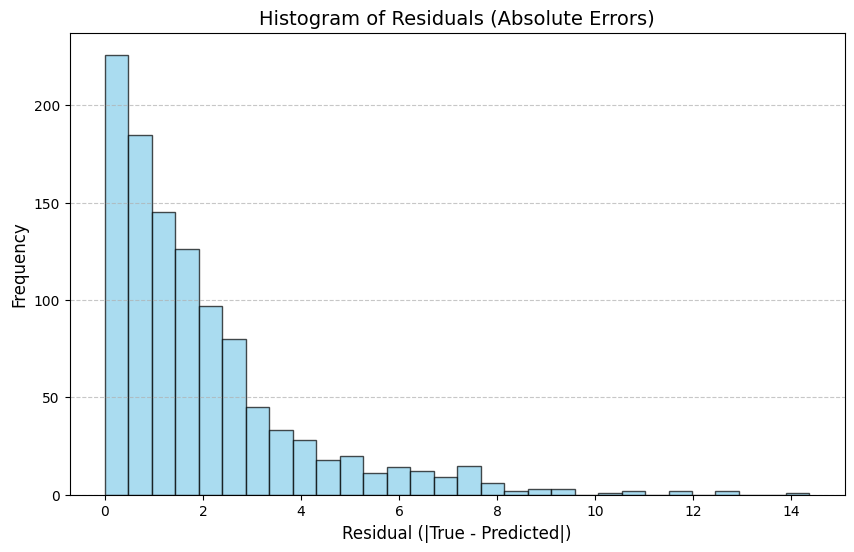

Mean Residual: 1.9814445163413825
Median Residual: 1.3941817021463523
Max Residual: 14.368306128183999


In [ ]:
# 5.C.1: Plotting Histogram of Residuals
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title("Histogram of Residuals (Absolute Errors)", fontsize=14)
plt.xlabel("Residual (|True - Predicted|)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print("Mean Residual:", np.mean(residuals))
print("Median Residual:", np.median(residuals))
print("Max Residual:", np.max(residuals))


## 5.D Cleaned Data after Removing High Residuals
This sections shows the data after removing the high residuals

Number of points removed: 96


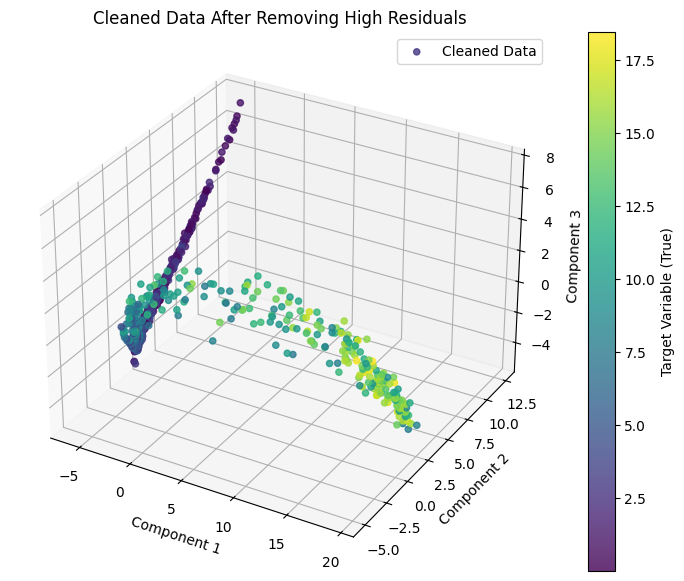

Removed Points with High Residuals:


,task_name,task_actual_hours,Residuals
3,OPF: Issues-Card: Unable to create a card if n...,1.35,5.16
22,OPF: Org/Workforce Exec - Schedule Manager: No...,4.82,10.18
27,OPF: Profile - Job preferences: Can submit for...,4.57,6.20
32,OPF: HR - Incident Report: Missing remarks on ...,2.21,6.00
34,Department Manager - Reports Redirection does ...,9.52,6.79
...,...,...,...
1100,Administration - Templates: Unable to save cha...,8.22,6.35
1105,Manager - Leave Requests: Modify the empty sta...,9.31,7.34
1145,HQZen Admin: TimelogIssueSubpage unit testcase,14.08,6.81
1154,Employment - Incidents Report: IR with Pending...,2.95,5.17


In [ ]:
from IPython.display import display

threshold = 5

# 5.D.1: Computing residuals (absolute errors)
residuals = np.abs(y_test - y_pred_final)

# 5.D.2: Filter out points with residuals above the threshold
condition = residuals <= threshold
X_test_clean = X_test[condition]
y_test_clean = y_test[condition]


print(f"Number of points removed: {len(y_test) - len(y_test_clean)}")

# 5.D.3: Visualize the cleaned dataset
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    X_test_clean[:, 0], X_test_clean[:, 1], X_test_clean[:, 2],
    c=y_test_clean, cmap='viridis', label='Cleaned Data', alpha=0.8
)
plt.colorbar(sc, label="Target Variable (True)")
ax.set_title("Cleaned Data After Removing High Residuals")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
plt.legend()
plt.show()

# 5.D.4: Identify indices of points above the threshold (high residuals)
removed_indices = np.where(residuals > threshold)[0]
removed_points_df = df.iloc[removed_indices].copy()
removed_points_df['Residuals'] = residuals[removed_indices]
print("Removed Points with High Residuals:")
display(removed_points_df[['task_name', 'task_actual_hours', 'Residuals']])


# 6. Training and Testing Regression Models
- The final step of the pipeline involves feeding the dim reduced embeddings into a regression model to output the duration prediction (in hours). Various linear and non-linear regression models were examined:

$$ F_{\text{Reg}}(\cdot) $$

$$ \hat{y}_{\text{act}} = F_{\text{Reg}}(\mathbf{z}) $$
$$ \frac{\partial \hat{y}_{\text{act}}}{\partial \mathbf{z}_i} = \nabla (\hat{y}_{\text{act}}, \mathbf{z}_i) $$


Metrics:

1. Coefficient of Determination (R²):

$$
R^2 = 1 - \frac{\sum_{i=1}^n (y_{\text{true}, i} - y_{\text{pred}, i})^2}{\sum_{i=1}^n (y_{\text{true}, i} - \bar{y}_{\text{true}})^2}
$$

2. Mean Absolute Error (MAE):

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_{\text{true}, i} - y_{\text{pred}, i}|
$$


3. Mean Squared Error (MSE):

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_{\text{true}, i} - y_{\text{pred}, i})^2
$$

## 6.A LazyRegessor Training and Testing
Since Lazypredict offers almost all Sklearn regression models. I decided to use this library so we could try all of them. Then we'll get the best performing regressors and apply Optuna.

In [ ]:
# 6.A.1: Initialize LazyRegressor
reg = LazyRegressor(verbose=1, ignore_warnings=True, custom_metric=None)

# 6.A.2: Fit and Evaluate
models, predictions = reg.fit(X_train, X_test_clean, y_train, y_test_clean)
print(models)

  2%|▏         | 1/42 [00:00<00:04,  8.23it/s]

{'Model': 'AdaBoostRegressor', 'R-Squared': 0.7371633996258651, 'Adjusted R-Squared': 0.7363636939452135, 'RMSE': 2.3261449384852595, 'Time taken': 0.12157821655273438}


 17%|█▋        | 7/42 [00:00<00:02, 12.66it/s]

{'Model': 'BaggingRegressor', 'R-Squared': 0.7599495771281493, 'Adjusted R-Squared': 0.7592192005879712, 'RMSE': 2.2230287967532, 'Time taken': 0.42154407501220703}
{'Model': 'BayesianRidge', 'R-Squared': 0.7983133890998018, 'Adjusted R-Squared': 0.797699738153858, 'RMSE': 2.0376631190651, 'Time taken': 0.009169816970825195}
{'Model': 'DecisionTreeRegressor', 'R-Squared': 0.46912220272893346, 'Adjusted R-Squared': 0.4675069558812527, 'RMSE': 3.3059108056946123, 'Time taken': 0.057034969329833984}
{'Model': 'DummyRegressor', 'R-Squared': -0.008601298062282936, 'Adjusted R-Squared': -0.011670064689247361, 'RMSE': 4.556733316907716, 'Time taken': 0.004992008209228516}
{'Model': 'ElasticNet', 'R-Squared': 0.6252461315543163, 'Adjusted R-Squared': 0.6241059068024531, 'RMSE': 2.7775821538809056, 'Time taken': 0.0061969757080078125}
{'Model': 'ElasticNetCV', 'R-Squared': 0.7981446797151446, 'Adjusted R-Squared': 0.7975305154546429, 'RMSE': 2.0385151861125683, 'Time taken': 0.05594348907470703

 21%|██▏       | 9/42 [00:01<00:08,  3.94it/s]

{'Model': 'ExtraTreesRegressor', 'R-Squared': 0.7510106719065939, 'Adjusted R-Squared': 0.7502530978860257, 'RMSE': 2.264040635806802, 'Time taken': 1.2467634677886963}
{'Model': 'GammaRegressor', 'R-Squared': 0.5555528341982116, 'Adjusted R-Squared': 0.554200560874271, 'RMSE': 3.024850544594155, 'Time taken': 0.12404227256774902}


 26%|██▌       | 11/42 [00:03<00:14,  2.08it/s]

{'Model': 'GaussianProcessRegressor', 'R-Squared': -3.117946390996888, 'Adjusted R-Squared': -3.1304756396510376, 'RMSE': 9.207340305801878, 'Time taken': 1.8355991840362549}


 29%|██▊       | 12/42 [00:05<00:18,  1.65it/s]

{'Model': 'GradientBoostingRegressor', 'R-Squared': 0.8213889815255896, 'Adjusted R-Squared': 0.8208455402929088, 'RMSE': 1.9175556397911917, 'Time taken': 1.1771469116210938}


 31%|███       | 13/42 [00:05<00:15,  1.89it/s]

{'Model': 'HistGradientBoostingRegressor', 'R-Squared': 0.803148218903018, 'Adjusted R-Squared': 0.802549278392581, 'RMSE': 2.013091546533981, 'Time taken': 0.22351670265197754}
{'Model': 'HuberRegressor', 'R-Squared': 0.7994927988319231, 'Adjusted R-Squared': 0.7988827363537241, 'RMSE': 2.031696527158233, 'Time taken': 0.016103744506835938}
{'Model': 'KNeighborsRegressor', 'R-Squared': 0.7688924734121436, 'Adjusted R-Squared': 0.7681893064955476, 'RMSE': 2.181227154336671, 'Time taken': 0.01315450668334961}


 52%|█████▏    | 22/42 [00:06<00:03,  5.50it/s]

{'Model': 'KernelRidge', 'R-Squared': -0.8258352713415198, 'Adjusted R-Squared': -0.8313905510717681, 'RMSE': 6.1309058528091755, 'Time taken': 0.7461433410644531}
{'Model': 'Lars', 'R-Squared': 0.7983249286177011, 'Adjusted R-Squared': 0.7977113127818523, 'RMSE': 2.037604825690359, 'Time taken': 0.008002042770385742}
{'Model': 'LarsCV', 'R-Squared': 0.7983249286177011, 'Adjusted R-Squared': 0.7977113127818523, 'RMSE': 2.037604825690359, 'Time taken': 0.012816667556762695}
{'Model': 'Lasso', 'R-Squared': 0.6816897258133598, 'Adjusted R-Squared': 0.6807212361353072, 'RMSE': 2.559877476631834, 'Time taken': 0.00798487663269043}
{'Model': 'LassoCV', 'R-Squared': 0.7983027456944417, 'Adjusted R-Squared': 0.7976890623649115, 'RMSE': 2.03771688413247, 'Time taken': 0.06034994125366211}
{'Model': 'LassoLars', 'R-Squared': 0.6816895140956649, 'Adjusted R-Squared': 0.6807210237734407, 'RMSE': 2.559878327957274, 'Time taken': 0.0061130523681640625}
{'Model': 'LassoLarsCV', 'R-Squared': 0.7983249

 62%|██████▏   | 26/42 [00:08<00:04,  3.45it/s]

{'Model': 'MLPRegressor', 'R-Squared': 0.8268481224603799, 'Adjusted R-Squared': 0.8263212911899753, 'RMSE': 1.888023751192538, 'Time taken': 1.9243738651275635}


 67%|██████▋   | 28/42 [00:08<00:04,  3.38it/s]

{'Model': 'NuSVR', 'R-Squared': 0.8279518329632952, 'Adjusted R-Squared': 0.8274283598384371, 'RMSE': 1.881996779360587, 'Time taken': 0.6329846382141113}
{'Model': 'OrthogonalMatchingPursuit', 'R-Squared': 0.715286267035395, 'Adjusted R-Squared': 0.7144199980709995, 'RMSE': 2.421018224214913, 'Time taken': 0.007046222686767578}
{'Model': 'OrthogonalMatchingPursuitCV', 'R-Squared': 0.798324922530971, 'Adjusted R-Squared': 0.7977113066766027, 'RMSE': 2.0376048564387075, 'Time taken': 0.014173269271850586}
{'Model': 'PassiveAggressiveRegressor', 'R-Squared': 0.7918760903125209, 'Adjusted R-Squared': 0.7912428532647903, 'RMSE': 2.069926090582124, 'Time taken': 0.00899815559387207}
{'Model': 'PoissonRegressor', 'R-Squared': 0.7663787552501731, 'Adjusted R-Squared': 0.7656679401038754, 'RMSE': 2.193057494821043, 'Time taken': 0.024309158325195312}
{'Model': 'RANSACRegressor', 'R-Squared': 0.6026092996897622, 'Adjusted R-Squared': 0.6014002001959176, 'RMSE': 2.860241480107281, 'Time taken': 

 81%|████████  | 34/42 [00:12<00:03,  2.07it/s]

{'Model': 'RandomForestRegressor', 'R-Squared': 0.7790061639622925, 'Adjusted R-Squared': 0.7783337689236383, 'RMSE': 2.132965991879315, 'Time taken': 4.1028594970703125}
{'Model': 'Ridge', 'R-Squared': 0.7983163835677067, 'Adjusted R-Squared': 0.79770274173272, 'RMSE': 2.0376479922814417, 'Time taken': 0.006999015808105469}
{'Model': 'RidgeCV', 'R-Squared': 0.7983163945108489, 'Adjusted R-Squared': 0.7977027527091578, 'RMSE': 2.0376479370011165, 'Time taken': 0.006319999694824219}
{'Model': 'SGDRegressor', 'R-Squared': 0.7974254530301915, 'Adjusted R-Squared': 0.7968091004532043, 'RMSE': 2.042143653354563, 'Time taken': 0.01119089126586914}


100%|██████████| 42/42 [00:13<00:00,  3.02it/s]

{'Model': 'SVR', 'R-Squared': 0.8272802382255708, 'Adjusted R-Squared': 0.8267547217090158, 'RMSE': 1.8856664147350015, 'Time taken': 0.7774143218994141}
{'Model': 'TransformedTargetRegressor', 'R-Squared': 0.7983249412084399, 'Adjusted R-Squared': 0.7977113254108996, 'RMSE': 2.0376047620856945, 'Time taken': 0.007279872894287109}
{'Model': 'TweedieRegressor', 'R-Squared': 0.5883107718836076, 'Adjusted R-Squared': 0.5870581677412656, 'RMSE': 2.911243974930362, 'Time taken': 0.007016420364379883}
{'Model': 'XGBRegressor', 'R-Squared': 0.7494798466311126, 'Adjusted R-Squared': 0.7487176149271504, 'RMSE': 2.2709898087335696, 'Time taken': 0.08278775215148926}
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 765
[LightGBM] [Info] Number of data points in the train set: 4341, number of used features: 3
[LightGBM] [Info] Start training from score 5.955

## 6.B Top 1 Best LazyRegressor Model (NuSVR) - Optimized

$$
\min_{\mathbf{w}, \xi, \xi^*} \frac{1}{2} \|\mathbf{w}\|^2 + \nu n^{-1} \sum_{i=1}^n (\xi_i + \xi_i^*)
$$

subject to:

$$
y_i - (\mathbf{w}^\top \phi(x_i) + b) \leq \epsilon + \xi_i, \quad \forall i
$$

$$
(\mathbf{w}^\top \phi(x_i) + b) - y_i \leq \epsilon + \xi_i^*, \quad \forall i
$$

$$
\xi_i, \xi_i^* \geq 0, \quad \forall i
$$

where:

- $ \mathbf{w} $: Weight vector.
- $ b $: Bias term.
- $ \phi(x) $: Kernel function mapping the input $ x $ into a higher-dimensional space.
- $ \epsilon $: Epsilon-insensitive margin.
- $ \nu $: Proportion of support vectors allowed and tolerance for margin violations ($ \nu \in (0, 1] $).
- $ \xi, \xi^* $: Slack variables representing the margin violations.

---

### Kernel Function

1. **Linear Kernel**:
   $$
   K(x_i, x_j) = x_i^\top x_j
   $$

2. **Polynomial Kernel**:
   $$
   K(x_i, x_j) = (\gamma x_i^\top x_j + r)^{d}
   $$

3. **RBF Kernel**:
   $$
   K(x_i, x_j) = \exp(-\gamma \|x_i - x_j\|^2)
   $$

In [ ]:
import optuna
from sklearn.svm import NuSVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd


def objective(trial):
    nu = trial.suggest_float("nu", 0.1, 0.9)  # Regularization parameter
    C = trial.suggest_float("C", 0.1, 100.0, log=True)  # Penalty parameter
    kernel = trial.suggest_categorical("kernel", ["linear", "poly", "rbf", "sigmoid"])  # Kernel type
    degree = trial.suggest_int("degree", 2, 5) if kernel == "poly" else 3  # Degree of the polynomial kernel
    gamma = trial.suggest_categorical("gamma", ["scale", "auto"])  # Kernel coefficient

    # 6.B.1: Preprocessing pipeline
    numeric_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler())
    ])
    preprocessor = ColumnTransformer(
        transformers=[
            ("numeric", numeric_transformer, list(range(X_train.shape[1])))
        ]
    )


    nusvr_pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("regressor", NuSVR(
            nu=nu,
            C=C,
            kernel=kernel,
            degree=degree,
            gamma=gamma
        ))
    ])

    # 6.B.2: Train the model
    nusvr_pipeline.fit(X_train, y_train)

    # 6.B.3: Predict and evaluate
    y_pred = nusvr_pipeline.predict(X_test_clean)
    r2 = r2_score(y_test_clean, y_pred)

    return r2  # Optuna will maximize R²


study = optuna.create_study(direction="maximize")  # Maximize R²
study.optimize(objective, n_trials=50)  # Run 50 trials
print("\n--- Best Trial ---")
print(f"Value (R²): {study.best_trial.value:.4f}")
print("Best Hyperparameters:", study.best_trial.params)

# 6.B.4: Train Final Model with Best Parameters
best_params = study.best_trial.params


numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, list(range(X_train.shape[1])))
    ]
)

# 6.B.5: Final NuSVR pipeline
final_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", NuSVR(
        nu=best_params["nu"],
        C=best_params["C"],
        kernel=best_params["kernel"],
        degree=best_params.get("degree", 3),
        gamma=best_params["gamma"]
    ))
])

final_pipeline.fit(X_train, y_train)
y_pred = final_pipeline.predict(X_test_clean)
mse = mean_squared_error(y_test_clean, y_pred)
r2 = r2_score(y_test_clean, y_pred)
adj_r2 = 1 - (1 - r2) * ((len(y_test_clean) - 1) / (len(y_test_clean) - X_test_clean.shape[1] - 1))


print("\n--- Final NuSVR Regression Results ---")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Adjusted R² Score: {adj_r2:.4f}")


[I 2025-01-14 19:12:51,644] A new study created in memory with name: no-name-4daa2162-2d55-4eed-9ce9-04c9b793ce22
[I 2025-01-14 19:12:52,377] Trial 0 finished with value: 0.8245146560594729 and parameters: {'nu': 0.7028835940931606, 'C': 0.14560356103619285, 'kernel': 'rbf', 'gamma': 'scale'}. Best is trial 0 with value: 0.8245146560594729.
[I 2025-01-14 19:12:53,023] Trial 1 finished with value: -82770.09150048273 and parameters: {'nu': 0.6291186115677623, 'C': 13.744026175956646, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.8245146560594729.
[I 2025-01-14 19:12:53,646] Trial 2 finished with value: -3.0433264468883143 and parameters: {'nu': 0.5381458043759666, 'C': 0.10848625277896558, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is trial 0 with value: 0.8245146560594729.
[I 2025-01-14 19:12:54,380] Trial 3 finished with value: -5.891436552458387 and parameters: {'nu': 0.7479966528049986, 'C': 0.12742020496401626, 'kernel': 'sigmoid', 'gamma': 'auto'}. Best is t


--- Best Trial ---
Value (R²): 0.8298
Best Hyperparameters: {'nu': 0.5074701759996665, 'C': 53.61450207616263, 'kernel': 'rbf', 'gamma': 'scale'}

--- Final NuSVR Regression Results ---
Mean Squared Error (MSE): 3.5035
R² Score: 0.8298
Adjusted R² Score: 0.8293


## 6.C Top-k Ensemble Model via Voting - Optimized
The **Voting Regressor** is an ensemble learning method that combines predictions from multiple base regressors to produce a single prediction. The final prediction is computed as the average of the six best regression models that were determind from lazypredict

### Formula for Voting
Given $ m $ base regressors and $ n $ data points, the prediction for the $ i $-th data point, $ \hat{y}_i $, is:

$$
\hat{y}_i = \frac{1}{m} \sum_{j=1}^{m} \hat{y}_{i,j}
$$

where:
- $ \hat{y}_i $: Final prediction for the $ i $-th data point.
- $ \hat{y}_{i,j} $: Prediction of the $ j $-th regressor for the $ i $-th data point.
- $ m $: Total number of regressors in the ensemble.

In [ ]:
import optuna
from sklearn.ensemble import VotingRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.svm import NuSVR, SVR
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np

# 6.C.1: Preprocessing for numeric and categorical features
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler())
])

categorical_low_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoding", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

categorical_high_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("encoding", OrdinalEncoder())
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, [0, 1]),
        ("categorical_low", categorical_low_transformer, []),
        ("categorical_high", categorical_high_transformer, [])
    ]
)

# 6.C.2: Objective Function for Optuna
def objective(trial):
    nusvr_nu = trial.suggest_float('nusvr_nu', 0.1, 0.9)
    nusvr_C_val = trial.suggest_float('nusvr_C', 1e-1, 100, log=True)
    svr_C_val = trial.suggest_float('svr_C', 1e-1, 100, log=True)
    svr_epsilon = trial.suggest_float('svr_epsilon', 0.01, 1.0)
    hidden_layer_sizes = trial.suggest_categorical('mlp_hidden_layer_sizes', [(2,), (4,), (8,), (2, 2), (4, 4)])
    alpha_mlp = trial.suggest_float('mlp_alpha', 1e-5, 1e-2, log=True)
    learning_rate_gbr = trial.suggest_float('gbr_learning_rate', 0.01, 0.3)
    max_depth_gbr = trial.suggest_int('gbr_max_depth', 3, 10)
    max_iter_hgb = trial.suggest_int('hgb_max_iter', 50, 500)
    learning_rate_hgb = trial.suggest_float('hgb_learning_rate', 0.01, 0.3)

    models = [
        ('nusvr', NuSVR(nu=nusvr_nu, C=nusvr_C_val, kernel='rbf')),
        ('svr', SVR(C=svr_C_val, epsilon=svr_epsilon, kernel='rbf')),
        ('mlp', MLPRegressor(hidden_layer_sizes=hidden_layer_sizes, alpha=alpha_mlp, max_iter=500)),
        ('gbr', GradientBoostingRegressor(learning_rate=learning_rate_gbr, max_depth=max_depth_gbr)),
        ('hgb', HistGradientBoostingRegressor(max_iter=max_iter_hgb, learning_rate=learning_rate_hgb))
    ]

    # 6.C.3: Create Voting Regressor
    voting = VotingRegressor(estimators=models)

    pipeline = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("voting", voting)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test_clean)

    # 6.C.4: Evaluate with R² (maximize)
    r2 = r2_score(y_test_clean, y_pred)
    return r2


study = optuna.create_study(direction='maximize')  # Maximize R²
study.optimize(objective, n_trials=50)  # Run 50 trials

print("\n--- Best Trial ---")
print(f"Best R²: {study.best_trial.value:.4f}")
print("Best Hyperparameters:", study.best_trial.params)


best_params = study.best_trial.params


optimized_models = [
    ('nusvr', NuSVR(nu=best_params['nusvr_nu'], C=best_params['nusvr_C'], kernel='rbf')),
    ('svr', SVR(C=best_params['svr_C'], epsilon=best_params['svr_epsilon'], kernel='rbf')),
    ('mlp', MLPRegressor(hidden_layer_sizes=best_params['mlp_hidden_layer_sizes'], alpha=best_params['mlp_alpha'], max_iter=500)),
    ('gbr', GradientBoostingRegressor(learning_rate=best_params['gbr_learning_rate'], max_depth=best_params['gbr_max_depth'])),
    ('hgb', HistGradientBoostingRegressor(max_iter=best_params['hgb_max_iter'], learning_rate=best_params['hgb_learning_rate']))
]

optimized_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("voting", VotingRegressor(estimators=optimized_models))
])
optimized_pipeline.fit(X_train, y_train)
y_pred_optimized = optimized_pipeline.predict(X_test_clean)

# 6.C.5: Evaluate Final Model
mse_optimized = mean_squared_error(y_test_clean, y_pred_optimized)
r2_optimized = r2_score(y_test_clean, y_pred_optimized)

print("\n--- Final Model Evaluation ---")
print(f"Optimized Voting Regressor - MSE: {mse_optimized:.4f}")
print(f"Optimized Voting Regressor - R²: {r2_optimized:.4f}")


[I 2025-01-14 19:15:47,203] A new study created in memory with name: no-name-145632c8-7304-4856-9800-0d4d8006fd73
[I 2025-01-14 19:15:52,004] Trial 0 finished with value: 0.8177477350536075 and parameters: {'nusvr_nu': 0.3086737639759466, 'nusvr_C': 33.01130455649589, 'svr_C': 49.436533154240145, 'svr_epsilon': 0.12357270558378554, 'mlp_hidden_layer_sizes': (2,), 'mlp_alpha': 0.0010723460296536017, 'gbr_learning_rate': 0.1299932558849655, 'gbr_max_depth': 7, 'hgb_max_iter': 68, 'hgb_learning_rate': 0.01898658381447811}. Best is trial 0 with value: 0.8177477350536075.
[I 2025-01-14 19:15:56,558] Trial 1 finished with value: 0.8148086528907731 and parameters: {'nusvr_nu': 0.2134154118414635, 'nusvr_C': 0.1623446871015811, 'svr_C': 61.19808925154373, 'svr_epsilon': 0.4328924488496246, 'mlp_hidden_layer_sizes': (8,), 'mlp_alpha': 0.0009483359054350761, 'gbr_learning_rate': 0.2925405076054482, 'gbr_max_depth': 6, 'hgb_max_iter': 133, 'hgb_learning_rate': 0.12391902408061173}. Best is trial 


--- Best Trial ---
Best R²: 0.8236
Best Hyperparameters: {'nusvr_nu': 0.5094223977340192, 'nusvr_C': 1.3143088991795302, 'svr_C': 95.9969716248827, 'svr_epsilon': 0.21779961129733516, 'mlp_hidden_layer_sizes': (4,), 'mlp_alpha': 0.00010277737522348353, 'gbr_learning_rate': 0.04653181108460401, 'gbr_max_depth': 5, 'hgb_max_iter': 80, 'hgb_learning_rate': 0.1116634139280018}

--- Final Model Evaluation ---
Optimized Voting Regressor - MSE: 3.6247
Optimized Voting Regressor - R²: 0.8239


## 6.D XGBoost Regressor - Optimized

In [ ]:
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
import numpy as np



def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0),
        'objective': 'reg:squarederror',  # Objective for regression
        'eval_metric': 'rmse'  # Pass eval_metric as part of params
    }


    model = xgb.XGBRegressor(**params)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=False  # Suppresses verbose output during training
    )


    y_pred = model.predict(X_test_clean)
    r2 = r2_score(y_test_clean, y_pred)
    return r2


study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)  # Run 50 trials


print("Best Trial:")
print(study.best_trial)


print("Best Hyperparameters:", study.best_trial.params)
best_params = study.best_trial.params


final_model = xgb.XGBRegressor(**best_params)
final_model.fit(X_train, y_train)


y_pred_final = final_model.predict(X_test_clean)
mse_final = mean_squared_error(y_test_clean, y_pred_final)
r2_final = r2_score(y_test_clean, y_pred_final)

print(f"Optimized XGBoost - MSE: {mse_final:.4f}")
print(f"Optimized XGBoost - R²: {r2_final:.4f}")


[I 2025-01-14 19:21:04,239] A new study created in memory with name: no-name-b92af176-8f92-4424-9e9b-864ef3ad7745
[I 2025-01-14 19:21:04,434] Trial 0 finished with value: 0.8168529223772311 and parameters: {'max_depth': 5, 'learning_rate': 0.03138394361598283, 'n_estimators': 229, 'min_child_weight': 5.802948377754298, 'gamma': 0.12077475480816913, 'subsample': 0.6042659981449623, 'colsample_bytree': 0.743852726156943, 'reg_alpha': 0.2109837124299234, 'reg_lambda': 0.7518213343721634}. Best is trial 0 with value: 0.8168529223772311.
[I 2025-01-14 19:21:05,018] Trial 1 finished with value: 0.7413121506668212 and parameters: {'max_depth': 5, 'learning_rate': 0.12088203347428382, 'n_estimators': 862, 'min_child_weight': 8.560646855407425, 'gamma': 0.4532671670611116, 'subsample': 0.5300996325451172, 'colsample_bytree': 0.9822671769193803, 'reg_alpha': 0.5223313723488915, 'reg_lambda': 0.6504218678225622}. Best is trial 0 with value: 0.8168529223772311.
[I 2025-01-14 19:21:06,137] Trial 2 

Best Trial:
FrozenTrial(number=69, state=1, values=[0.8247852087150407], datetime_start=datetime.datetime(2025, 1, 14, 19, 21, 33, 710722), datetime_complete=datetime.datetime(2025, 1, 14, 19, 21, 33, 916950), params={'max_depth': 3, 'learning_rate': 0.032673432444209984, 'n_estimators': 164, 'min_child_weight': 7.295537357093164, 'gamma': 0.03505607462649796, 'subsample': 0.6177395220013626, 'colsample_bytree': 0.7920221452786143, 'reg_alpha': 0.08520363334180095, 'reg_lambda': 0.43064311729717725}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'max_depth': IntDistribution(high=12, log=False, low=3, step=1), 'learning_rate': FloatDistribution(high=0.3, log=False, low=0.01, step=None), 'n_estimators': IntDistribution(high=1000, log=False, low=100, step=1), 'min_child_weight': FloatDistribution(high=10.0, log=False, low=1.0, step=None), 'gamma': FloatDistribution(high=0.5, log=False, low=0.0, step=None), 'subsample': FloatDistribution(high=1.0, log=False, low=0.

## 6.E Top 2 Best LazyRegressor Model (MLP) - Optimized
The **Multilayer Perceptron (MLP)** consists of an input layer, one or more hidden layers, and an output layer. The computations involve linear transformations at each layer.

1. Input Layer
The input to the network is a feature vector:

$$
\mathbf{x} = [x_1, x_2, \dots, x_d]
$$

2. Hidden Layers

$$
\mathbf{z}^{(l)} = \mathbf{W}^{(l)} \mathbf{a}^{(l-1)} + \mathbf{b}^{(l)}
$$

3. Output Layer

$$
\hat{\mathbf{y}} = \mathbf{W}^{(L)} \mathbf{a}^{(L-1)} + \mathbf{b}^{(L)}
$$

Loss Function (Regression)
$$
\mathcal{L}(\mathbf{y}, \hat{\mathbf{y}}) = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2
$$

In [ ]:
import optuna
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np


def objective(trial):
    hidden_layer_sizes = tuple([trial.suggest_int(f"n_units_{i}", 64, 512) for i in range(trial.suggest_int("n_layers", 1, 3))])
    learning_rate_init = trial.suggest_float("learning_rate_init", 1e-5, 1e-3, log=True)
    alpha = trial.suggest_float("alpha", 1e-3, 1e-1, log=True)
    activation = trial.suggest_categorical("activation", ["relu", "tanh"])
    solver = trial.suggest_categorical("solver", ["adam", "sgd"])
    batch_size = trial.suggest_int("batch_size", 32, 128)

    model = MLPRegressor(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=1000,
        learning_rate_init=learning_rate_init,
        alpha=alpha,
        activation=activation,
        solver=solver,
        batch_size=batch_size,
        early_stopping=True,
        n_iter_no_change=20,
        random_state=42
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_clean)

    if np.isnan(y_pred).sum() > 0:
        print("NaNs detected in predictions. Returning -inf to avoid errors.")
        return -np.inf

    return r2_score(y_test_clean, y_pred)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("Best Trial:", study.best_trial)
best_params = study.best_trial.params

final_model = MLPRegressor(
    hidden_layer_sizes=tuple([best_params[f"n_units_{i}"] for i in range(best_params['n_layers'])]),
    max_iter=1000,
    learning_rate_init=best_params["learning_rate_init"],
    alpha=best_params["alpha"],
    activation=best_params["activation"],
    solver=best_params["solver"],
    batch_size=best_params["batch_size"],
    early_stopping=True,
    n_iter_no_change=20,
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test_clean)

mse_final = mean_squared_error(y_test_clean, y_pred_final)
r2_final = r2_score(y_test_clean, y_pred_final)

print(f"Optimized MLP - MSE: {mse_final:.4f}")
print(f"Optimized MLP - R²: {r2_final:.4f}")


[I 2025-01-14 19:23:57,647] A new study created in memory with name: no-name-1db054d9-acab-4bad-9a7d-d4d718093a77
[I 2025-01-14 19:24:01,482] Trial 0 finished with value: 0.8212966160762163 and parameters: {'n_layers': 1, 'n_units_0': 440, 'learning_rate_init': 0.00030927425093348363, 'alpha': 0.042359219916485176, 'activation': 'relu', 'solver': 'adam', 'batch_size': 121}. Best is trial 0 with value: 0.8212966160762163.
[I 2025-01-14 19:24:07,029] Trial 1 finished with value: 0.8196807206561347 and parameters: {'n_layers': 1, 'n_units_0': 193, 'learning_rate_init': 0.000137558122226472, 'alpha': 0.0017888219895688057, 'activation': 'relu', 'solver': 'adam', 'batch_size': 55}. Best is trial 0 with value: 0.8212966160762163.
[I 2025-01-14 19:24:29,387] Trial 2 finished with value: 0.8171874570165049 and parameters: {'n_layers': 1, 'n_units_0': 454, 'learning_rate_init': 1.3650050556919221e-05, 'alpha': 0.02163498659827594, 'activation': 'relu', 'solver': 'adam', 'batch_size': 46}. Best 

Best Trial: FrozenTrial(number=14, state=1, values=[0.8321308107197001], datetime_start=datetime.datetime(2025, 1, 14, 19, 26, 53, 335609), datetime_complete=datetime.datetime(2025, 1, 14, 19, 27, 17, 614622), params={'n_layers': 3, 'n_units_0': 282, 'n_units_1': 66, 'n_units_2': 66, 'learning_rate_init': 4.544851259921226e-05, 'alpha': 0.003454109805859794, 'activation': 'tanh', 'solver': 'adam', 'batch_size': 72}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'n_layers': IntDistribution(high=3, log=False, low=1, step=1), 'n_units_0': IntDistribution(high=512, log=False, low=64, step=1), 'n_units_1': IntDistribution(high=512, log=False, low=64, step=1), 'n_units_2': IntDistribution(high=512, log=False, low=64, step=1), 'learning_rate_init': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'alpha': FloatDistribution(high=0.1, log=True, low=0.001, step=None), 'activation': CategoricalDistribution(choices=('relu', 'tanh')), 'solver': CategoricalDist

## 6.F Bi-LSTM Regressor - Optimize
- I decided to go with this Bi-LSTM for testing with Gradio later since I already used MLP for the detection and removal of points with high residuals


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import optuna
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 6.F.1: Convert data to PyTorch tensors and move to GPU
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)
X_test_tensor = torch.tensor(X_test_clean, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_clean, dtype=torch.float32).view(-1, 1).to(device)

# 6.F.2: Define Bi-LSTM Model
class BiLSTMRegressor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(BiLSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 for bidirectional

    def forward(self, x):
        out, _ = self.lstm(x.unsqueeze(1))  # Add sequence dimension
        out = self.dropout(out[:, -1, :])  # Last hidden state
        out = self.fc(out)
        return out

# 6.F.3: Optuna Objective Function
def objective(trial):
    hidden_dim = trial.suggest_int("hidden_dim", 32, 512)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_int("batch_size", 16, 64)
    epochs = 50


    model = BiLSTMRegressor(input_dim=3, hidden_dim=hidden_dim, num_layers=num_layers, dropout=dropout).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()


    model.train()
    for epoch in range(epochs):
        permutation = torch.randperm(X_train_tensor.size(0))
        for i in range(0, X_train_tensor.size(0), batch_size):
            indices = permutation[i:i + batch_size]
            batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()


    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).squeeze().cpu().numpy()  # Move back to CPU for scoring

    r2 = r2_score(y_test_clean, y_pred)
    if np.isnan(r2):
        return -np.inf
    return r2

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)


print("Best Trial:", study.best_trial)
best_params = study.best_trial.params

# 6.F.4: Re-train the best Bi-LSTM model
best_model = BiLSTMRegressor(
    input_dim=3,
    hidden_dim=best_params['hidden_dim'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
).to(device)
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])
criterion = nn.MSELoss()

# 6.F.5: Final Training
epochs = 100
for epoch in range(epochs):
    permutation = torch.randperm(X_train_tensor.size(0))
    for i in range(0, X_train_tensor.size(0), best_params['batch_size']):
        indices = permutation[i:i + best_params['batch_size']]
        batch_x, batch_y = X_train_tensor[indices], y_train_tensor[indices]

        optimizer.zero_grad()
        outputs = best_model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

# 6.F.6: Evaluate Final Model
best_model.eval()
with torch.no_grad():
    y_pred_final = best_model(X_test_tensor).squeeze().cpu().numpy()

mse_final = mean_squared_error(y_test_clean, y_pred_final)
r2_final = r2_score(y_test_clean, y_pred_final)

print(f"Bi-LSTM Optimized (CUDA) - MSE: {mse_final:.4f}")
print(f"Bi-LSTM Optimized (CUDA) - R²: {r2_final:.4f}")

[I 2025-01-14 20:18:25,093] A new study created in memory with name: no-name-836532b1-2af9-4d09-b687-81fcaf1ab17f


Using device: cuda


[I 2025-01-14 20:18:57,436] Trial 0 finished with value: 0.829398682485987 and parameters: {'hidden_dim': 210, 'num_layers': 3, 'dropout': 0.1224809531339016, 'learning_rate': 0.0005722214814818999, 'batch_size': 46}. Best is trial 0 with value: 0.829398682485987.
[I 2025-01-14 20:19:12,604] Trial 1 finished with value: 0.828476093556285 and parameters: {'hidden_dim': 340, 'num_layers': 1, 'dropout': 0.2204274137391185, 'learning_rate': 0.0029273861797667507, 'batch_size': 53}. Best is trial 0 with value: 0.829398682485987.
[I 2025-01-14 20:20:04,511] Trial 2 finished with value: 0.8276451133299161 and parameters: {'hidden_dim': 374, 'num_layers': 3, 'dropout': 0.4086726640538515, 'learning_rate': 0.00030419872256498396, 'batch_size': 44}. Best is trial 0 with value: 0.829398682485987.
[I 2025-01-14 20:20:21,439] Trial 3 finished with value: 0.8209787716751701 and parameters: {'hidden_dim': 81, 'num_layers': 3, 'dropout': 0.3655818361504325, 'learning_rate': 0.00017936579432911067, 'ba

Best Trial: FrozenTrial(number=13, state=1, values=[0.8319900950646202], datetime_start=datetime.datetime(2025, 1, 14, 20, 24, 48, 916252), datetime_complete=datetime.datetime(2025, 1, 14, 20, 26, 3, 752529), params={'hidden_dim': 37, 'num_layers': 3, 'dropout': 0.20564157844531128, 'learning_rate': 0.001010094132470376, 'batch_size': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'hidden_dim': IntDistribution(high=512, log=False, low=32, step=1), 'num_layers': IntDistribution(high=3, log=False, low=1, step=1), 'dropout': FloatDistribution(high=0.5, log=False, low=0.1, step=None), 'learning_rate': FloatDistribution(high=0.01, log=True, low=0.0001, step=None), 'batch_size': IntDistribution(high=64, log=False, low=16, step=1)}, trial_id=13, value=None)
Bi-LSTM Optimized (CUDA) - MSE: 3.4794
Bi-LSTM Optimized (CUDA) - R²: 0.8310


In [ ]:
torch.save({
    'model_state_dict': best_model.state_dict(),
    'model_params': {
        'input_dim': 3,
        'hidden_dim': best_params['hidden_dim'],
        'num_layers': best_params['num_layers'],
        'dropout': best_params['dropout']
    }
}, "best_bilstm_model_with_params.pth")
print("Model and parameters saved successfully!")

Model and parameters saved successfully!


# 7. Inference Testing via Gradio

In [ ]:
import gradio as gr
from gradio.themes import Base
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch
import numpy as np
import joblib
import time

# 7.0.1: Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 7.0.2: Load Pretrained BERT Model and Tokenizer
bert_model_path = r'C:/Users/Jeryl Salas/AppData/Local/Programs/Microsoft VS Code/bert-task-regressor'
bert_model = AutoModel.from_pretrained(bert_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(bert_model_path)

# 7.0.3: Load the saved KPCA and scaler
loaded_model_data = joblib.load("best_kpca_model_v2.pkl")
loaded_scaler = loaded_model_data["scaler"]
loaded_kpca = loaded_model_data["kpca"]

# 7.0.4: Define Bi-LSTM Model Class
class BiLSTMRegressor(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(BiLSTMRegressor, self).__init__()
        self.lstm = torch.nn.LSTM(
            input_dim, hidden_dim, num_layers=num_layers,
            batch_first=True, bidirectional=True
        )
        self.dropout = torch.nn.Dropout(dropout)
        self.fc = torch.nn.Linear(hidden_dim * 2, 1)  # *2 for bidirectional

    def forward(self, x):
        out, _ = self.lstm(x)  # Expecting [batch_size, sequence_length, input_size]
        out = self.dropout(out[:, -1, :])  # Last hidden state
        out = self.fc(out)
        return out

# 7.0.5: Load Saved Bi-LSTM Model and Parameters
checkpoint_path = "best_bilstm_model_with_params.pth"
checkpoint = torch.load(checkpoint_path)
model_params = checkpoint['model_params']

# 7.0.6: Reconstruct the Bi-LSTM model
bilstm_model = BiLSTMRegressor(
    input_dim=model_params['input_dim'],
    hidden_dim=model_params['hidden_dim'],
    num_layers=model_params['num_layers'],
    dropout=model_params['dropout']
).to(device)

print(f"Using fine-tuned model for embedding and tokenization: {bert_model}")
print(f"Using BiLSTM model for regression: {bilstm_model}")
print(f"with KPCA model for dim reduce: {loaded_model_data}")
bilstm_model.load_state_dict(checkpoint['model_state_dict'])
bilstm_model.eval()
print("Model and parameters loaded successfully!")

# 7.0.7: Function to process a single task name and generate embeddings
def process_embeddings(task_name):
    inputs = tokenizer(task_name, padding=True, truncation=True, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = bert_model(**inputs)
        embedding = outputs.last_hidden_state[:, 0, :]  # CLS embeddings
    return embedding

# 7.0.8: Gradio Interface Function
def predict_task_duration(task_name):
    start_time = time.time()
    embedding = process_embeddings(task_name)
    embedding = embedding.cpu().numpy()  # Move tensor to CPU and convert to NumPy
    embedding = embedding.reshape(embedding.shape[0], -1)
    embedding_scaled = loaded_scaler.transform(embedding)
    embedding_kpca = loaded_kpca.transform(embedding_scaled)
    embedding_kpca_tensor = torch.tensor(embedding_kpca, dtype=torch.float32).to(device)
    embedding_kpca_tensor = embedding_kpca_tensor.unsqueeze(0)

    # Predict task duration using the Bi-LSTM model
    with torch.no_grad():
        predicted_duration = bilstm_model(embedding_kpca_tensor).cpu().numpy()  # Move prediction to CPU

    end_time = time.time()
    print(f"Task Estimation Processed in {end_time-start_time} seconds")
    return f"Estimated Task Duration: {predicted_duration[0][0]:.2f} hours"

# 7.0.9: Gradio Interface
interface = gr.Interface(
    fn=predict_task_duration,
    inputs=gr.Textbox(label="Task Name", placeholder="Enter the task name..."),  # No 'live' here
    outputs=gr.Textbox(label="Estimated Duration (hours)"),
    title="Task Duration Estimator v2",
    description="Enter a task name to estimate its duration (in hours) using the trained BERT, Bi-LSTM, and KPCA models.",
    theme=Base(primary_hue="green", neutral_hue="slate"),
    live=True  # Enable live updates at the Interface level
)


interface.launch()


Using device: cuda
Using fine-tuned model for embedding and tokenization: BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, el

Task Estimation Processed in 0.09550881385803223 seconds
Task Estimation Processed in 0.09342241287231445 seconds
Task Estimation Processed in 0.0871438980102539 seconds
Task Estimation Processed in 0.08836102485656738 seconds
Task Estimation Processed in 0.08880496025085449 seconds
Task Estimation Processed in 0.09158110618591309 seconds
Task Estimation Processed in 0.08989739418029785 seconds
Task Estimation Processed in 0.09086871147155762 seconds
Task Estimation Processed in 0.0870659351348877 seconds
Task Estimation Processed in 0.08772134780883789 seconds
Task Estimation Processed in 0.08868265151977539 seconds
Task Estimation Processed in 0.0892341136932373 seconds
Task Estimation Processed in 0.08906197547912598 seconds
Task Estimation Processed in 0.08929610252380371 seconds
Task Estimation Processed in 0.04918074607849121 seconds
Task Estimation Processed in 0.04969310760498047 seconds
Task Estimation Processed in 0.09362626075744629 seconds
Task Estimation Processed in 0.095